In [ ]:
#load libraries and setup file
import sys,os
root_path = os.path.abspath(os.path.join('..'))
print(root_path)
if root_path not in sys.path:
    sys.path.append(root_path)
%run -i "../lib/utils/ipynb_setup.py"
%load_ext autoreload
%autoreload 2
%matplotlib inline

#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
# pl.rc("figure", facecolor="white",figsize = (8,8))
pl.rc("figure", facecolor="gray",figsize = (8,8))
pl.rc('text', usetex=False)
pl.rc('text.latex', preamble=r'\usepackage{amsmath}')
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 10)                                          

Get Corpus

In [2]:
# from lib.lib import process_data

question_label = 'carbontax_q3'

year='2019'
fig_dir='../../output/figures/'+year+'/'
data_dir='../../output/data/'+year+'/'
models_dir='../../output/stm_models/'+year+'/'
# from lib.lib import *
restypelist=['support','oppose','notsure']
max_char_length=512
fdf=pd.read_csv(data_dir+question_label+'_2019data.csv',sep='\t')

# when adding new responses, set reduce_to_stems_flag=False and scan the output vocabulary for nonwords to add to wordfixfile with their correction
# pd.options.display.max_rows=1500
# pd.options.display.max_colwidth=150
# print(cleaned_responses.to_string())
# vocabulary

# STM

## Preprocessing

In [3]:
# question_label = 'carbontax_q3'
# fdf=pd.read_csv(data_dir+question_label+'_data.csv',sep='\t')
# restypelist=['support','oppose','notsure'] #preferred order of types for plotting
fdf.head()

,id,res,restype,lang,sex,prov,livingenv,partisanship,caruse,partyvote,agedec,resclean
0,27,We already have too much tax on gas.,oppose,EN,Male,ON,suburban,right,none,conservative,60+,alreadi much tax ga
1,28,It will likely not be effective and the scienc...,oppose,EN,Male,ON,suburban,right,driver,conservative,30-39,like effect scienc uncertain
2,29,"The people who will be paying, the average low...",oppose,EN,Female,SK,urban,none,driver,conservative,40-49,peopl pay averag low middl class peopl suffer ...
3,30,the government is making to much money,oppose,EN,Male,AB,urban,none,none,progressive,19-29,govern make much money
4,31,job killer,oppose,EN,Male,AB,smalltown,right,driver,conservative,30-39,job killer


In R, so need to interface

In [3]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.lib import grdevices
from IPython.display import Image,display
pandas2ri.activate()

check versions

In [4]:
robjects.r("library('stm')"); 



#need to install stm ver. 1.3.6 R-package and its dependencies
#preprocessing: tm R-package,
#stm: quanteda R-package, ...
#n.b. might have to install xml2: sudo apt-get install libxml2-dev

#redefine topicquality function to output data
robjects.r('topicQuality <- function(model, documents, xlab="Semantic Coherence", ylab="Exclusivity", labels=1:ncol(model$theta), M=10,...){ \n'+\
  'args <- asSTMCorpus(documents) \n'+\
  'documents <- args$documents \n'+\
  'if(length(model$beta$logbeta)<2){ \n'+\
  '  semcoh <- semanticCoherence(model,documents=documents, M=M) \n'+\
  '  exclusivity <- exclusivity(model, M=M) \n'+\
  '  plot(0, 0, xlab=xlab, ylab=ylab, col="white", xlim=c(min(semcoh), max(semcoh)), \n'+\
  '       ylim=c(min(exclusivity), max(exclusivity)),...) \n'+\
  '  for(i in 1:length(labels)){ \n'+\
  '    text(semcoh[i], exclusivity[i], paste("Topic", labels[i])) \n'+\
  '  } \n'+\
  '  return(list(semcoh,exclusivity)) \n'+\
  '} \n'+\
  'if(length(model$beta$logbeta)>1){ \n'+\
  '  semcoh <- semanticCoherence(model,documents=documents, M=M) \n'+\
  '  for(i in 1:length(labels)){ \n'+\
  '    print(paste("Topic", i, "has", semcoh[i], "semantic coherence")) \n'+\
  '  } \n'+\
  '} \n'+\
'}');

def pre_process_stm(resp_data, occurs_in_morethan=1):
    with localconverter(robjects.default_converter + pandas2ri.converter):
        robjects.globalenv['doc_df'] = robjects.conversion.py2rpy(resp_data)

    robjects.r("processed_corpus_temp = textProcessor(doc_df$resclean, metadata=doc_df, lowercase=TRUE)");
    robjects.r(
        'processed_corpus = prepDocuments(processed_corpus_temp$documents,'+\
                                     'processed_corpus_temp$vocab,'+\
                                     'processed_corpus_temp$meta,'+\
                                     'lower.thresh='+str(occurs_in_morethan)+') \n'+\
        'rm(processed_corpus_temp); invisible(gc())'
    );
    print()
    
def batch_run_and_save(params,plot_flag = True):
    (fig_dir,data_dir,models_dir)=params['dirs']
    for K in params['Krange']:
        for seed in params['seedlist']:
            run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
            #run inference
#             robjects.r("fitobj<-stm(documents=processed_corpus$documents[preprocessed_corpus$meta$restype="+params["res_type"]+"],vocab=processed_corpus$vocab,K="+str(K)+\
            robjects.r("fitobj<-stm(documents=processed_corpus$documents,vocab=processed_corpus$vocab,K="+str(K)+\
                ",prevalence="+params['model_str']+", max.em.its=500,data=processed_corpus$meta,seed="+str(seed)+"," +\
                "sigma.prior = "+str(params['sigma_prior'])+",verbose=FALSE"+\
            ")")
            robjects.r('save(fitobj, file = "'+models_dir+run_name+'.rda")')
            robjects.r('rm(fitobj)')
            if plot_flag:
                load_singlerun_and_plot(K,run_name,models_dir,fig_dir,data_dir)
    np.save(models_dir+params['batch_name']+'.npy',params)

def load_singlerun_and_plot(K,run_name,models_dir,fig_dir,data_dir):
    robjects.r('load(file = "'+models_dir+run_name+'.rda")')

#         #wordcloud
#         with grdevices.render_to_bytesio(grdevices.jpeg,width=1024, height=1024, res=150) as img:
#             robjects.r.cloud(robjects.globalenv['fitobj'])
#         img_obj=Image(data=img.getvalue())
#         open(fig_dir+batch_name+str(K)+"_wordcloud.jpeg", "wb").write(img_obj.data)

    #topic wordlists
    shownwords=10
    test1=robjects.r('labelTopics(fitobj,n='+str(shownwords)+')')
    topicwords=pd.Series(np.asarray(test1.rx[1][0]).reshape((shownwords,K)).T.tolist(),index=range(1,K+1))
    topicwords.index.name='topicid'
    topicwords.to_csv(data_dir+run_name+'_topicwordlists.csv')

    #prevalence plot
    with grdevices.render_to_bytesio(grdevices.jpeg,width=1024, height=1024, res=150) as img:
        robjects.r.plot(robjects.globalenv['fitobj'])
    img_obj=Image(data=img.getvalue())
    open(fig_dir+run_name+"_topicprevalence.jpeg", "wb").write(img_obj.data)
#     display(img_obj)

    #correlation matrix
    corrdata=robjects.r.topicCorr(robjects.globalenv['fitobj'])
    import scipy.cluster.hierarchy as sch
    d=sch.distance.pdist(corrdata[2])
    L=sch.linkage(d,method='complete')
    ind=sch.fcluster(L,0.5*d.max(),'distance')
    new_order = np.array([np.arange(K)[i] for i in list((np.argsort(ind)))])
    fig,ax=pl.subplots()
    p=ax.imshow(corrdata[2][:,new_order][new_order],cmap='RdBu',vmin=-1,vmax=1)
    ax.set_yticks(np.arange(K));
    ax.set_yticklabels(new_order+1);
    ax.set_xticks(np.arange(K));
    ax.set_xticklabels(new_order+1);
    ax.grid(False)
    cb=fig.colorbar(p,fraction=0.046,pad=0.04)
    cb.set_label(r'$\rho$',rotation=0)
    fig.savefig(fig_dir+run_name+"_corrmatrices.png", transparent=True,bbox_inches="tight",dpi=300)

    #correlation graph
    with grdevices.render_to_bytesio(grdevices.jpeg,width=512, height=512, res=150) as img:
        robjects.r.plot(corrdata)
    img_obj=Image(data=img.getvalue())
    open(fig_dir+run_name+"_corrgraph.jpeg", "wb").write(img_obj.data)
    
def load_plot_batch(params,ax,models_dir,fig_dir,data_dir):

    #load data
    qual_data={}
    for K in params['Krange']:
        qual_data[K]={}
        for seed in params['seedlist']:
            qual_data[K][seed]={}
            run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
            robjects.r('load(file = "'+models_dir+run_name+'.rda")')

            #topic quality
            datatmp=robjects.r.topicQuality(model=robjects.globalenv['fitobj'],documents=robjects.r("processed_corpus$documents"))
            qual_data[K][seed]['excl']=datatmp[1]
            qual_data[K][seed]['semcoh']=datatmp[0]
    
    #plot for each seed
    colors=pl.get_cmap('viridis',len(params['Krange']))(range(len(params['Krange'])))
    if params['batch_name'][0]=='o':
        mkr='o' 
    elif params['batch_name'][0]=='s':
        mkr='s'
    else:
        mkr='v'
    
#     ax.plot([0],[0],'k'+mkr,label=params['restype'])
    for sit,seed in enumerate(params['seedlist']):
        for kit,K in enumerate(params['Krange']):
            if sit==0 and params['restype']=='support':
                p=ax.plot(qual_data[K][seed]['semcoh'], qual_data[K][seed]['excl'],mkr,mew=0,color=colors[kit],label=str(K),alpha=0.5)
            else:
                p=ax.plot(qual_data[K][seed]['semcoh'], qual_data[K][seed]['excl'],mkr,mew=0,color=colors[kit],alpha=0.5)
            ax.plot([np.mean(qual_data[K][seed]['semcoh'])], [np.mean(qual_data[K][seed]['excl'])],mkr,color=colors[kit],mec='k',mew=1,zorder=4)
        ax.set_xlabel('semantic coherence')
        ax.set_ylabel('exclusivity')
        ax.set_ylim(8.4,10)
        ax.set_xlim(-300,-100)
        ax.legend(frameon=False,loc='center left',bbox_to_anchor=(1.04,0.5))
    np.save(data_dir+batch_name+'_batch_data.npy',qual_data)

from scipy import linalg
from math import factorial,gamma
def get_volume_and_participation_ratio(mtr, get_vectors =False):
    if get_vectors:
        eigen_values, eigen_vectors=linalg.eigh(mtr)#     print(np.argmin(np.fabs([x.real for x in eigen_values])))
        eigen_vectors=np.delete(eigen_vectors,np.argmin(eigen_values),axis=1)
    else:
        eigen_values=linalg.eigvals(mtr).real
    eigen_values=np.delete(eigen_values,np.argmin(eigen_values))
    d=len(eigen_values)
#     prefac= 2**d * np.power(np.pi,(d-1)/2)*gamma((d-1)/2+1)/gamma(d+1) if d %2 else np.power(np.pi,d/2)/gamma(d/2+1)
                                
    if get_vectors:
        return np.power(np.prod(eigen_values),1/(2*d)),(np.sum(eigen_values)**2)/np.sum(np.power(eigen_values,2)), eigen_values,eigen_vectors
    else:
        return np.power(np.prod(eigen_values),1/(2*d)),(np.sum(eigen_values)**2)/np.sum(np.power(eigen_values,2)),eigen_values
    
def compute_geometrics(sig_dict,run_label_stem,meta_data_names,models_dir,fdf):
    nsamples=1000

    for sigma,sigma_label,in sig_dict.items():
        
        run_label=run_label_stem+'_sigma'+sigma_label
        
        for mode in ['all','separate']:
            fig,ax=pl.subplots(1,4,figsize=(12,3))
            col_names=['restype','K','volume','position','eccentricity','orientation']
            dattmp_df=pd.DataFrame(columns=col_names)
            batch_name = "all_reponses_" + run_label
            params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()
            dattmp_store=np.zeros((3,len(params['Krange']),4))

#             if mode=='all':
#                 resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
            for rit,restype in enumerate(['support','oppose']):
                if mode=='separate':
                    resp_data=fdf.loc[fdf.restype==restype,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
                elif mode=='all':
                    resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)

                pre_process_stm(resp_data)
                pcorp=dict(robjects.r.processed_corpus.items())

                #run preprocessing on data to have access to text responses (produces 'processsed_corpus' in R)
                batch_name = "all_reponses_" + run_label if mode=='all' else restype+"_reponses_" + run_label
                params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()

                #load specific model output
                seed=1
                nrows=3
                figsize=3
                for kit,K in enumerate(params['Krange']):

                    run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
                    robjects.r('load(file = "'+models_dir+run_name+'.rda")');

                    fitobj=dict(robjects.r.fitobj.items())
                    if mode=='all':
                        data=fitobj['theta'][pcorp['meta']['restype'].values==restype] 
                    elif mode=='separate':
                        data=fitobj['theta']

                    covariance_matrix = np.cov(data.T)
                    correlation_matrix = np.corrcoef(data.T)
                    cov_eigen_values, cov_eigen_vectors=linalg.eigh(covariance_matrix)
                    corr_eigen_values, corr_eigen_vectors=linalg.eigh(correlation_matrix)
                    sig_cov_eigen_values, sig_cov_eigen_vectors=linalg.eigh(fitobj['sigma']) 
        #             prefac= 2**d * np.power(np.pi,(d-1)/2)*gamma((d-1)/2+1)/gamma(d+1) if d %2 else np.power(np.pi,d/2)/gamma(d/2+1)
                    volume = np.power(np.exp(np.sum(np.log10(cov_eigen_values[1:]))),1/(K-1))
        #             volume = np.power(np.linalg.det(covariance_matrix),1/(K-1))
        #             position = np.mean(np.linalg.norm(res_data-np.ones(K)[np.newaxis,:]/K))
                    entropy = np.mean(-np.sum(fitobj['theta']*np.log2(fitobj['theta']),axis=1))
                    position = (np.log2(K)-entropy)/np.log2(K)
                    eccenticity = (np.sum(cov_eigen_values[1:])**2)/np.sum(np.power(cov_eigen_values[1:],2))/(K-1)
                    corr_thresh = 0.01
                    orientation = np.mean(correlation_matrix[~np.eye(K,dtype=bool)]>corr_thresh)#/(K**2-K)
                    dattmp_store[rit,kit,:]=[volume,position,eccenticity,orientation]

                    theta_posterior_samples_all=np.array([dat for dat in robjects.r.thetaPosterior(robjects.globalenv['fitobj'],nsims=nsamples)])                      
                    if mode=='separate':      
                        theta_posterior_samples=np.swapaxes(theta_posterior_samples_all,0,1)
                    elif mode=='all':
                        theta_posterior_samples=np.swapaxes(theta_posterior_samples_all[pcorp['meta']['restype'].values==restype],0,1)
                    
                    for sample in range(nsamples):
                        theta_data=theta_posterior_samples[sample]
                        entropies=[]
                        for row in theta_data:
                            entropies.append(-np.sum(row*np.log2(row)))
                        corrdata=np.array(pd.DataFrame(theta_data).corr())
                        covdata=np.cov(theta_data.T)
                        import scipy.cluster.hierarchy as sch
                        d=sch.distance.pdist(corrdata)
                        L=sch.linkage(d,method='complete')
                        ind=sch.fcluster(L,0.5*d.max(),'distance')
                        new_order = np.array([np.arange(K)[i] for i in list((np.argsort(ind)))])
                        covariance_matrix=covdata[:,new_order][new_order]
                        data=corrdata[~np.eye(K,dtype=bool)]
                        vol,part_ratio,eigen_values=get_volume_and_participation_ratio(covariance_matrix,get_vectors=False)
                        dattmp_df.loc[len(dattmp_df.index)]=[restype,K,vol,(np.log2(K)-np.mean(entropies))/np.log2(K),part_ratio/(K-1),np.mean(data>0.01)]#/(K**2-K)]

        for ait,axit in enumerate(ax):    
            sns.lineplot(ax=axit,
                     x='K',
                    y=col_names[2+ait],
                    data=dattmp_df.loc[:,col_names[:2]+[col_names[2+ait]]].reset_index(),
                    hue='restype',
                     ci='sd',
                         palette=sns.color_palette("colorblind", 2),)#,
            for rrit,rrestype in enumerate(['support','oppose']):
                axit.plot(params['Krange'],dattmp_store[rrit,:,ait],'--',color=sns.color_palette("colorblind", 2)[rrit])
        ax[1].get_legend().remove()
        ax[2].get_legend().remove()
        ax[3].get_legend().remove()
        # ax[2].set_ylim(0.5,1.0)
        # ax[3].set_ylim(0,0.5)
        ax[0].legend(frameon=False)
        ax[2].set_xlabel(r'number of topics, $K$')
        ax[2].set_ylabel(r'dimensionality fraction')
        # ax[2].set_title(r'Covariation')
        ax[0].set_xlabel(r'number of topics, $K$')
        ax[0].set_ylabel(r'normalized $K$-volume')
        # ax[0].set_title(r'Size')
        # ax[2].set_xlabel(r'# effective dimensions')
        ax[1].set_xlabel(r'number of topics, $K$')
        ax[1].set_ylabel('normalized weight entropy')
        # ax[1].set_title('Bias')
    #         ax[1].set_ylim(0,0.5)
        ax[3].set_xlabel(r'number of topics, $K$')
        ax[3].set_ylabel(r'positive fraction ($c > 0.01$)')
        # ax[3].set_title('Rigidity')
        fig.suptitle(run_label_stem+' '+year+' '+mode+' $\sigma='+str(sigma)+'$')
        fig.tight_layout()
        fig.savefig(fig_dir+run_name+"_"+str(sig_dict[sigma])+'_'+mode+"_geometrics_nsamp1000.png", transparent=True,bbox_inches="tight",dpi=300)
    
def compute_plotgeometrics(sig_dict,run_label_stem,meta_data_names,models_dir,fdf):
    nsamples=100

    for sigma,sigma_label,in sig_dict.items():
        
        run_label=run_label_stem+'_sigma'+sigma_label
        
        for mode in ['all','separate']:
            
            col_names=['restype','K','volume','position','eccentricity','orientation']
            dattmp_df=pd.DataFrame(columns=col_names)
            batch_name = "all_reponses_" + run_label
            params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()
            dattmp_store=np.zeros((3,len(params['Krange']),4))

#             if mode=='all':
#                 resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
            for rit,restype in enumerate(['support','oppose']):
                if mode=='separate':
                    resp_data=fdf.loc[fdf.restype==restype,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
                elif mode=='all':
                    resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)

                pre_process_stm(resp_data)
                pcorp=dict(robjects.r.processed_corpus.items())

                #run preprocessing on data to have access to text responses (produces 'processsed_corpus' in R)
                batch_name = "all_reponses_" + run_label if mode=='all' else restype+"_reponses_" + run_label
                params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()

                #load specific model output
                seed=1
                nrows=3
                figsize=3
                for kit,K in enumerate(params['Krange']):

                    run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
                    robjects.r('load(file = "'+models_dir+run_name+'.rda")');

                    fitobj=dict(robjects.r.fitobj.items())
                    
                    
                    for statmode in ['samples']:
                        if statmode == 'posterior_avg':
                            if mode=='all':
                                data=fitobj['theta'][pcorp['meta']['restype'].values==restype] 
                            elif mode=='separate':
                                data=fitobj['theta']
                        else:
                            theta_posterior_samples_all=np.array([dat for dat in robjects.r.thetaPosterior(robjects.globalenv['fitobj'],nsims=nsamples)])                      
                            if mode=='separate':      
                                theta_posterior_samples=np.swapaxes(theta_posterior_samples_all,0,1)
                            elif mode=='all':
                                theta_posterior_samples=np.swapaxes(theta_posterior_samples_all[pcorp['meta']['restype'].values==restype],0,1)
                            dims=theta_posterior_samples.shape
                            data = theta_posterior_samples.reshape(dims[0]*dims[1],dims[2])

                        geo_mean = np.exp(np.mean(np.log(data),axis=1))                    
                        metric_var = np.sum(np.var(np.log(data/geo_mean[:,np.newaxis]),axis=0))
                        volume = metric_var/K

                        metric_center = np.exp(np.mean(np.log(data),axis=0))
                        metric_center = metric_center/np.sum(metric_center)
                        tmp_mtr=np.log(metric_center[np.newaxis,:]/metric_center[:,np.newaxis])
                        position = np.sqrt(1/K*np.sum(np.power(np.triu(tmp_mtr,1),2)))

                        covariance_matrix = np.cov(data.T)
                        cov_eigen_values, cov_eigen_vectors=linalg.eigh(covariance_matrix)
                        sig_cov_eigen_values, sig_cov_eigen_vectors=linalg.eigh(fitobj['sigma']) 
                        eccenticity = (np.sum(cov_eigen_values[1:])**2)/np.sum(np.power(cov_eigen_values[1:],2))/(K-1)

                        correlation_matrix = np.corrcoef(data.T)
                        corr_eigen_values, corr_eigen_vectors=linalg.eigh(correlation_matrix)
                        corr_thresh = 0.01
                        orientation = np.mean(correlation_matrix[~np.eye(K,dtype=bool)]>corr_thresh)#/(K**2-K)

                        dattmp_store[rit,kit,:]=[volume,position,eccenticity,orientation]

                    
                    
#                     dattmp_df.loc[len(dattmp_df.index)]=[restype,K,vol,(np.log2(K)-np.mean(entropies))/np.log2(K),part_ratio/(K-1),np.mean(data>0.01)]#/(K**2-K)]

                    
#                     for sample in range(nsamples):
#                         theta_data=theta_posterior_samples[sample]
#                         entropies=[]
#                         for row in theta_data:
#                             entropies.append(-np.sum(row*np.log2(row)))
#                         corrdata=np.array(pd.DataFrame(theta_data).corr())
#                         covdata=np.cov(theta_data.T)
#                         import scipy.cluster.hierarchy as sch
#                         d=sch.distance.pdist(corrdata)
#                         L=sch.linkage(d,method='complete')
#                         ind=sch.fcluster(L,0.5*d.max(),'distance')
#                         new_order = np.array([np.arange(K)[i] for i in list((np.argsort(ind)))])
#                         covariance_matrix=covdata[:,new_order][new_order]
#                         data=corrdata[~np.eye(K,dtype=bool)]
#                         vol,part_ratio,eigen_values=get_volume_and_participation_ratio(covariance_matrix,get_vectors=False)
#                         dattmp_df.loc[len(dattmp_df.index)]=[restype,K,vol,(np.log2(K)-np.mean(entropies))/np.log2(K),part_ratio/(K-1),np.mean(data>0.01)]#/(K**2-K)]
        fig,ax=pl.subplots(1,4,figsize=(12,3))
        fig2,ax2=pl.subplots(1,4,figsize=(12,3))
        for ait,axit in enumerate(ax):    
#             sns.lineplot(ax=axit,
#                      x='K',
#                     y=col_names[2+ait],
#                     data=dattmp_df.loc[dattmp_df.K<8,col_names[:2]+[col_names[2+ait]]].reset_index(),
#                     hue='restype',
#                      ci='sd',
#                          palette=sns.color_palette("colorblind", 2),)#,
            for rrit,rrestype in enumerate(['support','oppose']):
                axit.plot(params['Krange'],dattmp_store[rrit,:,ait],'--',color=sns.color_palette("colorblind", 2)[rrit])
            ax2[ait].scatter(dattmp_store[0,:,ait],dattmp_store[1,:,ait], marker='o')
            axit.set_xticks(range(2,8))
            axit.set_xlim(2,7)
            
            ax2[ait].plot(ax2[ait].get_xlim(),ax2[ait].get_ylim(),'k--')
            ax2[ait].set_xlabel('support')
            ax2[ait].set_ylabel('oppose')
#         ax[1].get_legend().remove()
#         ax[2].get_legend().remove()
#         ax[3].get_legend().remove()
        ax[2].set_ylim(0.5,1.0)
        ax[2].set_yticks([0.5,0.75,1.0])
        ax[3].set_ylim(0,0.4)
        ax[3].set_yticks([0,0.1,0.2,0.3,0.4])
        ax[3].set_yticklabels([r"$0$","",r"$0.2$","",r"$0.4$"])
        ax[0].legend(frameon=False)
        ax[2].set_xlabel(r'number of topics, $K$')
        ax[2].set_ylabel(r'dimensionality fraction')
        # ax[2].set_title(r'Covariation')
        ax[0].set_xlabel(r'number of topics, $K$')
        ax[0].set_ylabel(r'normalized $K$-volume')
        # ax[0].set_title(r'Size')
        # ax[2].set_xlabel(r'# effective dimensions')
        ax[1].set_xlabel(r'number of topics, $K$')
        ax[1].set_ylabel('normalized weight entropy')
        # ax[1].set_title('Bias')
    #         ax[1].set_ylim(0,0.5)
        ax[3].set_xlabel(r'number of topics, $K$')
        ax[3].set_ylabel(r'positive fraction ($c > 0.01$)')
        # ax[3].set_title('Rigidity')
        fig.suptitle(run_label_stem+' '+year+' '+mode+' $\sigma='+str(sigma)+'$')
        fig.tight_layout()
#         fig.savefig(fig_dir+run_name+"_"+str(sig_dict[sigma])+'_'+mode+"_geometrics_nsamp1000.png", transparent=True,bbox_inches="tight",dpi=300)
 

R[write to console]: stm v1.3.6 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com



In [44]:
 meta_data_names=['restype',
                 'partisanship',
                 'partyvote',
                 'caruse',
                 'livingenv',
                 'agedec',
                 'sex',
                 'prov']

Separate response models

In [150]:
num_splits=200
Krange=np.arange(2,37,2) #sep
col_names=['restype','K','position','size','eccentricity','orientedness_pos','orientedness_neg','likelihood']
dattmp_df=pd.DataFrame(columns=col_names)
st=time.time()
for rit,restype in enumerate(['support','oppose']):
    resp_data=fdf.loc[fdf.restype==restype,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
    pre_process_stm(resp_data)
    pcorp=dict(robjects.r.processed_corpus.items())
    for split_seed in range(1,num_splits+1):
        robjects.r(
            f'heldout <-make.heldout(processed_corpus$documents,vocab=processed_corpus$vocab,N=floor(.1*length(processed_corpus$documents)),seed={split_seed})'
            );
        for K in Krange[1:]:
            filename='../../output/stm_models/2019/all_responses_sep_all_likeli_sigmad6_separate_'+restype+'_K_'+str(K)+'_seed_101_splitseed_'+str(split_seed)
            robjects.r('load(file = "'+filename+'.rda")');
            fitobj=dict(robjects.r.fitobj.items())
            outvar='mu'
            mu_arr=dict(fitobj[outvar].items())[outvar]

            covariance_matrix=np.cov(mu_arr)
            cov_eigen_values, cov_eigen_vectors=linalg.eigh(covariance_matrix)

            dim_K=(np.sum(cov_eigen_values)**2)/np.sum(np.power(cov_eigen_values,2))/len(covariance_matrix[0,:])
            pos_K=np.mean(np.linalg.norm(mu_arr,axis=1)/np.sqrt(K-1))
            vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
            var_K=np.sqrt(np.trace(covariance_matrix))/len(covariance_matrix[0,:])
            correlation_matrix = np.corrcoef(mu_arr)
            orientation = np.mean(correlation_matrix[(correlation_matrix>0) & (~np.eye(K-1,dtype=bool))])
            corrpos_K=orientation
            orientation = -np.mean(correlation_matrix[(correlation_matrix<0) & (~np.eye(K-1,dtype=bool))])
            corrneg_K=orientation
            
            likeli_K=robjects.r('eval.heldout(fitobj,heldout$missing)$expected.heldout')[0]

            dattmp_df.loc[len(dattmp_df.index)]=[restype,K,pos_K,var_K,dim_K,corrpos_K,corrneg_K,likeli_K]
            
            robjects.r('rm(fitobj)')
print(time.time-st)

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 585 of 1280 terms (585 of 9840 tokens) due to frequency 
Removing 5 Documents with No Words 
Your corpus now has 1295 documents, 695 terms and 9255 tokens.


/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalar

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalar

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _m

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _m

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalar

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(cova

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _m

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods.

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalar

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(cova

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _m

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(cova

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _m

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(cova

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods.

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _m

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _m

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalar

Building corpus... 


/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))


Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 774 of 1680 terms (774 of 13472 tokens) due to frequency 
Removing 5 Documents with No Words 
Your corpus now has 1567 documents, 906 terms and 12698 tokens.


/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(cova

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(cova

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _m

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalar

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalar

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods.

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(cova

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalar

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalar

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalar

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _m

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(cova

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalar

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _m

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(cova

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix)

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double

/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/303475864.py:26: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalar

/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in

TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


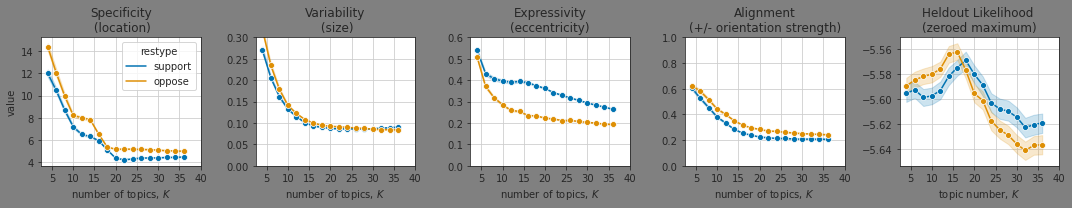

In [152]:
fig,ax=pl.subplots(1,5,figsize=(15,3))
for ait,axit in enumerate(ax[:-1]):    
    sns.lineplot(ax=axit,
        x='K',
        y=col_names[2+ait],
        data=dattmp_df.loc[:,col_names[:2]+[col_names[2+ait]]].reset_index(),
        hue='restype',
        ci=68,
         marker='o',
        palette=sns.color_palette("colorblind", 2),)#,
sns.lineplot(ax=ax[4],
        x='K',
        y='likelihood',
        data=dattmp_df.loc[:,col_names[:2]+['likelihood']].reset_index(),
        hue='restype',
        ci=68,
        marker='o',
        palette=sns.color_palette("colorblind", 2),)#,
# ax[4].legend(frameon=False)
# ax[4].set_ylim(-0.08,0.01)
ax[4].get_legend().remove()

ax[4].set_title('Heldout Likelihood \n(zeroed maximum)')
ax[4].set_xlabel(r'topic number, $K$')
ax[4].set_ylabel(None)
#     axx[0].plot(Krange[1:],pos_K)
# #     axx[0].set_ylabel(r'$\mathbb{E}\left[|| \theta||\right]/\sqrt{K-1}$')
#     p=axx[1].plot(Krange[1:],var_K)
#     axx[1].plot(Krange[1:],vardet_K,color=p[-1].get_color())
ax[1].set_ylim(0,0.3)
ax[2].set_ylim(0,0.6)
ax[3].set_ylim(0,0.6)
for a in ax:
    a.set_xticks(range(5,41,5))
#     if rit==0:
#         p=axx[3].plot(Krange[1:],corrpos_K,label=r'$\rho_{ij}>0$')
#         axx[3].plot(Krange[1:],corrneg_K,color=p[-1].get_color(),ls='--',label=r'$\rho_{ij}<0$')
#     else:
#         p=axx[3].plot(Krange[1:],corrpos_K)
#         axx[3].plot(Krange[1:],corrneg_K,color=p[-1].get_color(),ls='--')
# #         axx[3].spines['bottom'].set_position('zero')
ax[1].get_legend().remove()
ax[2].get_legend().remove()
ax[3].get_legend().remove()
axx[0].legend(frameon=False)
ax[0].set_xlabel(r'number of topics, $K$')
ax[0].set_ylabel('value')#r'mean position')
ax[0].set_title('Specificity\n (location)')
ax[1].set_xlabel(r'number of topics, $K$')
ax[1].set_ylabel(None)#'total variance')
ax[1].set_title('Variability\n (size)')
ax[2].set_xlabel(r'number of topics, $K$')
ax[2].set_ylabel(None)#r'dimensionality (fraction of total)')
ax[2].set_title('Expressivity\n(eccentricity)')
ax[3].set_xlabel(r'number of topics, $K$')
ax[3].set_ylabel(None)#r'unsigned mean correlation')
ax[3].set_title('Alignment\n(+/- orientation strength)')
ax[3].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
# opt_K=[16,18]
# for mtype in range(4):
#     for rit,restype in enumerate(['support','oppose']):
#         mean=dattmp_df.loc[(dattmp_df.restype==restype) & (dattmp_df.K==opt_K[rit]),col_names[2+mtype]].mean()
#         ax[mtype].plot([opt_K[rit]],[mean],'o',color=sns.color_palette("colorblind", 2)[rit])
# axx[3].legend(frameon=False)
fig.tight_layout()

Combined model

scatter

In [90]:
figg,axx=pl.subplots(1,4,figsize=(12,3))
# num_splits=200
Krange=[16,18,20,22,24]

resp_data=fdf.loc[fdf.restype!='notsure',['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
pre_process_stm(resp_data)
pcorp=dict(robjects.r.processed_corpus.items())
split_seed=100
for rit,restype in enumerate(['support','oppose']):
    dim_K=[]
    pos_K=[]
    var_K=[]
    vardet_K=[]
    corrpos_K=[]
    corrneg_K=[]
    likeli_K=[]
    for K in Krange:
        filename=f'../../output/stm_models/2019/all_responses_allfac_likelihood_sigmad6_all_K_'+str(K)+'_seed_101_splitseed_'+str(split_seed)
        robjects.r('load(file = "'+filename+'.rda")');

        fitobj=dict(robjects.r.fitobj.items())
        outvar='mu'
        mu_arr=dict(fitobj[outvar].items())[outvar]
        mu_arr=mu_arr[:,pcorp['meta']['restype'].values==restype] 

        covariance_matrix=np.cov(mu_arr)#pl.imshow(np.cov(mu_arr))
        cov_eigen_values, cov_eigen_vectors=linalg.eigh(covariance_matrix)
        dim_K.append((np.sum(cov_eigen_values)**2)/np.sum(np.power(cov_eigen_values,2))/len(covariance_matrix[0,:]))
        pos_K.append(np.mean(np.linalg.norm(mu_arr,axis=1)/np.sqrt(K-1)))
        vardet_K.append(np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:])))
        var_K.append(np.sqrt(np.trace(covariance_matrix))/len(covariance_matrix[0,:]))
        correlation_matrix = np.corrcoef(mu_arr)
        corr_thresh = 0.01
        orientation = np.mean(correlation_matrix[(correlation_matrix>0) & (~np.eye(K-1,dtype=bool))])#/np.mean(correlation_matrix[(correlation_matrix<0.01) & (~np.eye(K-1,dtype=bool))])#/(K**2-K)
        corrpos_K.append(orientation)
        orientation = np.fabs(np.mean(correlation_matrix[(correlation_matrix<0) & (~np.eye(K-1,dtype=bool))]))#/np.mean(correlation_matrix[(correlation_matrix<0.01) & (~np.eye(K-1,dtype=bool))])#/(K**2-K)
        corrneg_K.append(orientation)
        robjects.r(
        f'heldout <-make.heldout(processed_corpus$documents,vocab=processed_corpus$vocab,N=floor(.1*length(processed_corpus$documents)),seed={split_seed})'
        );
        likeli_K.append(robjects.r('eval.heldout(fitobj,heldout$missing)$expected.heldout')[0])
    if restype=='support':
        dim_Kp=dim_K
        pos_Kp=pos_K
        var_Kp=var_K
        vardet_Kp=vardet_K
        corrpos_Kp=corrpos_K
        corrneg_Kp=corrneg_K

        robjects.r('rm(fitobj)')
    likeli_K=np.array(likeli_K)
    likeli_K=100*((likeli_K-np.min(likeli_K))/(np.max(likeli_K)-np.min(likeli_K))+0.05)
    axx[0].scatter(pos_Kp,pos_K,s=likeli_K)
#     axx[0].set_ylabel(r'$\mathbb{E}\left[|| \theta||\right]/\sqrt{K-1}$')
    p=axx[1].scatter(var_Kp,var_K,s=likeli_K)
    axx[1].scatter(vardet_Kp,vardet_K,s=likeli_K,c=p.get_facecolors()[0].tolist())
#     axx[1].set_ylim(0,0.5)
    axx[2].scatter(dim_K,dim_K,s=likeli_K)
#     axx[2].set_ylim(0,1)
#     for ax in axx:
#         ax.set_xticks(range(4,40,4))
    if rit==0:
        p=axx[3].scatter(corrpos_Kp,corrpos_K,s=likeli_K,label=r'$\rho_{ij}>0$')
        axx[3].scatter(corrneg_Kp,corrneg_K,s=likeli_K,c=p.get_facecolors()[0].tolist(),marker='s',label=r'$\rho_{ij}<0$')
    else:
        p=axx[3].scatter(corrpos_Kp,corrpos_K,s=likeli_K)
        axx[3].scatter(corrneg_Kp,corrneg_K,s=likeli_K,c=p.get_facecolors()[0].tolist(),marker='s')
    #         axx[3].spines['bottom'].set_position('zero')
for ax in axx:
    ax.plot(ax.get_xlim(),ax.get_xlim(),'k--')
axx[0].legend(frameon=False)
# axx[0].set_xlabel(r'number of topics, $K$')
axx[0].set_ylabel(r'mean position')
axx[0].set_title('Specificity\n (location)')
# ax[2].set_xlabel(r'# effective dimensions')
# axx[1].set_xlabel(r'number of topics, $K$')
axx[1].set_ylabel('total variance')
axx[1].set_title('Variability\n (size)')
#         ax[1].set_ylim(0,0.5)

# axx[2].set_xlabel(r'number of topics, $K$')
axx[2].set_ylabel(r'dimensionality (fraction of total)')
axx[2].set_title('Expressivity\n(eccentricity)')

axx[3].set_xlabel(r'number of topics, $K$')
axx[3].set_ylabel(r'unsigned mean correlation')
axx[3].set_title('Alignment\n(+/- orientation strength)')
# axx[3].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axx[3].legend(frameon=False)
figg.tight_layout()

2864

over K

In [155]:
num_splits=100
Krange=[16,18,20,22,24]
col_names=['K','position','size','eccentricity','orientedness_pos','orientedness_neg','likelihood']
dattmp_comb_df=pd.DataFrame(columns=col_names)
resp_data=fdf.loc[fdf.restype!='notsure',['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
pre_process_stm(resp_data)
pcorp=dict(robjects.r.processed_corpus.items())
for split_seed in range(1,num_splits+1):
    robjects.r(
    f'heldout <-make.heldout(processed_corpus$documents,vocab=processed_corpus$vocab,N=floor(.1*length(processed_corpus$documents)),seed={split_seed})'
    );
    for K in Krange:
        filename='../../output/stm_models/2019/all_responses_allfac_likelihood_sigmad6_all_K_'+str(K)+'_seed_101_splitseed_'+str(split_seed)
        robjects.r('load(file = "'+filename+'.rda")');
        fitobj=dict(robjects.r.fitobj.items())
        outvar='mu'
        mu_arrt=dict(fitobj[outvar].items())[outvar]
        for rit,restype in enumerate(['support','oppose']):

            mu_arr=mu_arrt[:,pcorp['meta']['restype'].values==restype] 

            covariance_matrix=np.cov(mu_arr)
            cov_eigen_values, cov_eigen_vectors=linalg.eigh(covariance_matrix)

            dim_K=(np.sum(cov_eigen_values)**2)/np.sum(np.power(cov_eigen_values,2))/len(covariance_matrix[0,:])
            pos_K=np.mean(np.linalg.norm(mu_arr,axis=1)/np.sqrt(K-1))
            vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
            var_K=np.sqrt(np.trace(covariance_matrix))/len(covariance_matrix[0,:])
            correlation_matrix = np.corrcoef(mu_arr)
            orientation = np.mean(correlation_matrix[(correlation_matrix>0) & (~np.eye(K-1,dtype=bool))])
            corrpos_K=orientation
            orientation = -np.mean(correlation_matrix[(correlation_matrix<0) & (~np.eye(K-1,dtype=bool))])
            corrneg_K=orientation

            if restype=='support':
                data_tmp=[pos_K,var_K,dim_K,corrpos_K,corrneg_K]
            else:
                likeli_K=robjects.r('eval.heldout(fitobj,heldout$missing)$expected.heldout')[0]

                dattmp_comb_df.loc[len(dattmp_comb_df.index)]=[K,pos_K-data_tmp[0],var_K-data_tmp[1],dim_K-data_tmp[2],corrpos_K-data_tmp[3],corrneg_K-data_tmp[4],likeli_K]

        robjects.r('rm(fitobj)')

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 902 of 2104 terms (902 of 23312 tokens) due to frequency 
Removing 8 Documents with No Words 
Your corpus now has 2864 documents, 1202 terms and 22410 tokens.


/tmp/ipykernel_2720/1101015116.py:27: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/1101015116.py:27: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/1101015116.py:27: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/1101015116.py:27: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/1101015116.py:27: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/1101015116.py:27: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_m

/tmp/ipykernel_2720/1101015116.py:27: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/1101015116.py:27: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/1101015116.py:27: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/1101015116.py:27: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/1101015116.py:27: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:]))
/tmp/ipykernel_2720/1101015116.py:27: RuntimeWarning: invalid value encountered in power
  vardet_K=np.power(np.linalg.det(covariance_m

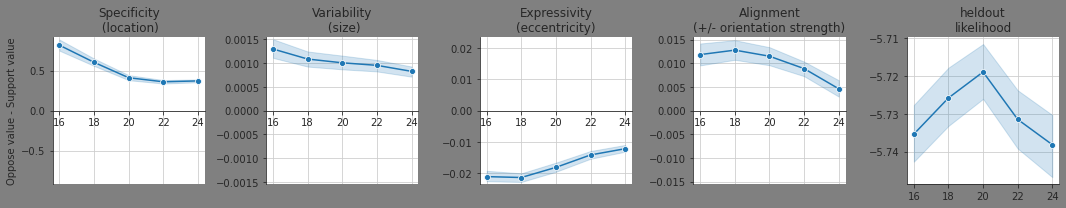

In [156]:
fig,ax=pl.subplots(1,5,figsize=(15,3))
for ait,axit in enumerate(ax[:-1]):    
    sns.lineplot(ax=axit,
        x='K',
        y=col_names[1+ait],
        data=dattmp_comb_df.loc[:,[col_names[0],col_names[1+ait]]].reset_index(),
#         hue='restype',
        marker='o',
        ci=68)#'sd')#,
    ylim=axit.get_ylim()
    if ait ==2:
        axit.set_ylim(ylim[0],-ylim[0])
    else:
        axit.set_ylim(-ylim[1],ylim[1])
    axit.spines['bottom'].set_position('zero')
    axit.spines['right'].set_visible(False)
    axit.spines['top'].set_visible(False)
    axit.set_xticks(Krange)

sns.lineplot(ax=ax[4],
        x='K',
        y='likelihood',
        data=dattmp_comb_df.loc[:,[col_names[0],'likelihood']].reset_index(),
#         hue='restype',
        marker='o',
        ci=68)#'sd')#,
ax[4].spines['right'].set_visible(False)
ax[4].spines['top'].set_visible(False)
ax[4].set_xticks(Krange)
ax[4].set_ylabel(None)#'heldout likelihood')
ax[4].set_xlabel(None)#r'number of topics, $K$')
ax[4].set_title('heldout\nlikelihood')

#     axx[0].plot(Krange[1:],pos_K)
# #     axx[0].set_ylabel(r'$\mathbb{E}\left[|| \theta||\right]/\sqrt{K-1}$')
#     p=axx[1].plot(Krange[1:],var_K)
#     axx[1].plot(Krange[1:],vardet_K,color=p[-1].get_color())
# ax[1].set_ylim(0,0.3)
# ax[2].set_ylim(0,0.6)
# ax[3].set_ylim(0,0.6)
# for a in ax:
#     a.set_xticks(range(5,41,5))
#     if rit==0:
#         p=axx[3].plot(Krange[1:],corrpos_K,label=r'$\rho_{ij}>0$')
#         axx[3].plot(Krange[1:],corrneg_K,color=p[-1].get_color(),ls='--',label=r'$\rho_{ij}<0$')
#     else:
#         p=axx[3].plot(Krange[1:],corrpos_K)
#         axx[3].plot(Krange[1:],corrneg_K,color=p[-1].get_color(),ls='--')
# ax[1].get_legend().remove()
# ax[2].get_legend().remove()
# ax[3].get_legend().remove()
# axx[0].legend(frameon=False)
ax[0].set_xlabel(None)#r'number of topics, $K$')
ax[0].set_ylabel('Oppose value - Support value')#r'mean position')
ax[0].set_title('Specificity\n (location)')
ax[1].set_xlabel(None)#r'number of topics, $K$')
ax[1].set_ylabel(None)#'total variance')
ax[1].set_title('Variability\n (size)')
ax[2].set_xlabel(None)#r'number of topics, $K$')
ax[2].set_ylabel(None)#r'dimensionality (fraction of total)')
ax[2].set_title('Expressivity\n(eccentricity)')
ax[3].set_xlabel(None)#r'number of topics, $K$')
ax[3].set_ylabel(None)#r'unsigned mean correlation')
ax[3].set_title('Alignment\n(+/- orientation strength)')
# ax[3].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
# opt_K=[16,18]
# mean=dattmp_df.loc[(dattmp_df.K==opt_K[rit]),'likelihood'].mean()
# for mtype in range(4):
#     ax[mtype].scatter(Krange,[opt_K[rit]],[mean],'o',color=sns.color_palette("colorblind", 2)[rit])
# axx[3].legend(frameon=False)
fig.tight_layout()

Combine two plots into one figure

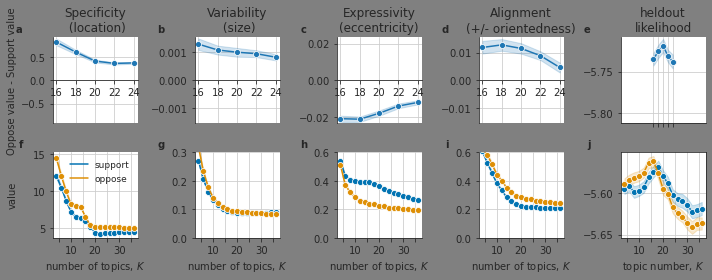

In [198]:
fig,ax=pl.subplots(2,5,figsize=(15*2/3,6*2/3))

Krange=np.arange(2,37,2) #sep
col_names=['restype','K','position','size','eccentricity','orientedness_pos','orientedness_neg','likelihood']
for ait,axit in enumerate(ax[1,:-1]):    
    sns.lineplot(ax=axit,
        x='K',
        y=col_names[2+ait],
        data=dattmp_df.loc[:,col_names[:2]+[col_names[2+ait]]].reset_index(),
        hue='restype',
        ci=68,
         marker='o',
        palette=sns.color_palette("colorblind", 2),)#,
    axit.spines['right'].set_visible(False)
    axit.spines['top'].set_visible(False)
sns.lineplot(ax=ax[1,4],
        x='K',
        y='likelihood',
        data=dattmp_df.loc[:,col_names[:2]+['likelihood']].reset_index(),
        hue='restype',
        ci=68,
        marker='o',
        palette=sns.color_palette("colorblind", 2),)#,
ax[1,0].legend(frameon=False,prop={'size':9})
# ax[4].set_ylim(-0.08,0.01)
ax[1,4].get_legend().remove()
ax[1,4].set_xlabel(r'topic number, $K$')
ax[1,4].set_ylabel(None)
ax[1,1].set_ylim(0,0.3)
ax[1,2].set_ylim(0,0.6)
ax[1,3].set_ylim(0,0.6)
for a in ax[1,:]:
    a.set_xticks(range(5,40,5))
    a.set_xticklabels(['',10,'',20,'',30,''])

ax[1,1].get_legend().remove()
ax[1,2].get_legend().remove()
ax[1,3].get_legend().remove()
ax[1,0].set_xlabel(r'number of topics, $K$')
ax[1,0].set_ylabel('value',labelpad=15)#r'mean position')
# ax[1,0].set_title('Specificity\n (location)')
ax[1,1].set_xlabel(r'number of topics, $K$')
ax[1,1].set_ylabel(None)#'total variance')
# ax[1,1].set_title('Variability\n (size)')
ax[1,2].set_xlabel(r'number of topics, $K$')
ax[1,2].set_ylabel(None)#r'dimensionality (fraction of total)')
# ax[1,2].set_title('Expressivity\n(eccentricity)')
ax[1,3].set_xlabel(r'number of topics, $K$')
ax[1,3].set_ylabel(None)#r'unsigned mean correlation')
# ax[1,3].set_title('Alignment\n(+/- orientation strength)')
# ax[1,3].set_yticks([0,0.2,0.4,0.6,0.8,1.0])


Krange=[16,18,20,22,24]
col_names=['K','position','size','eccentricity','orientedness_pos','orientedness_neg','likelihood']

for ait,axit in enumerate(ax[0,:-1]):    
    sns.lineplot(ax=axit,
        x='K',
        y=col_names[1+ait],
        data=dattmp_comb_df.loc[:,[col_names[0],col_names[1+ait]]].reset_index(),
#         hue='restype',
        marker='o',
        ci=68)#'sd')#,
    ylim=axit.get_ylim()
    if ait ==2:
        axit.set_ylim(ylim[0],-ylim[0])
    else:
        axit.set_ylim(-ylim[1],ylim[1])
    axit.spines['bottom'].set_position('zero')
    axit.spines['right'].set_visible(False)
    axit.spines['top'].set_visible(False)
    axit.set_xticks(Krange)

sns.lineplot(ax=ax[0,4],
        x='K',
        y='likelihood',
        data=dattmp_comb_df.loc[:,[col_names[0],'likelihood']].reset_index(),
#         hue='restype',
        marker='o',
        ci=68)#'sd')#,
ax[0,4].spines['right'].set_visible(False)
ax[0,4].spines['top'].set_visible(False)
ax[0,4].set_xticks(Krange)
ax[0,4].set_xticklabels([])
ax[0,4].set_xlim(ax[1,4].get_xlim())
diff=np.fabs(np.diff(ax[1,4].get_ylim()))[0]
ylim=ax[0,4].get_ylim()
ax[0,4].set_ylim(ylim[1]-diff,ylim[1])

ax[0,4].set_ylabel(None)#'heldout likelihood')
ax[0,4].set_xlabel(None)#r'number of topics, $K$')
ax[0,4].set_title('heldout\nlikelihood')
ax[0,0].set_xlabel(None)#r'number of topics, $K$')
ax[0,0].set_ylabel('Oppose value - Support value')#r'mean position')
ax[0,0].set_title('Specificity\n (location)')
ax[0,1].set_xlabel(None)#r'number of topics, $K$')
ax[0,1].set_ylabel(None)#'total variance')
ax[0,1].set_title('Variability\n (size)')
ax[0,2].set_xlabel(None)#r'number of topics, $K$')
ax[0,2].set_ylabel(None)#r'dimensionality (fraction of total)')
ax[0,2].set_title('Expressivity\n(eccentricity)')
ax[0,3].set_xlabel(None)#r'number of topics, $K$')
ax[0,3].set_ylabel(None)#r'unsigned mean correlation')
ax[0,3].set_title('Alignment\n(+/- orientedness)')

for ait,tup in enumerate(zip(['a','b','c','d','e','f','g','h','i','j'],ax.flatten())):
    label,axx=tup
    axx.text(-0.35,1.15,label,transform=axx.transAxes,fontsize=10,fontweight='bold',va='top',ha='right')
fig.tight_layout()

In [199]:
fig.savefig("metrics.pdf", transparent=True,bbox_inches="tight",dpi=300)


Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 902 of 2104 terms (902 of 23312 tokens) due to frequency 
Removing 8 Documents with No Words 
Your corpus now has 2864 documents, 1202 terms and 22410 tokens.


/tmp/ipykernel_2720/1624591456.py:30: RuntimeWarning: invalid value encountered in power
  vardet_K.append(np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:])))
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *

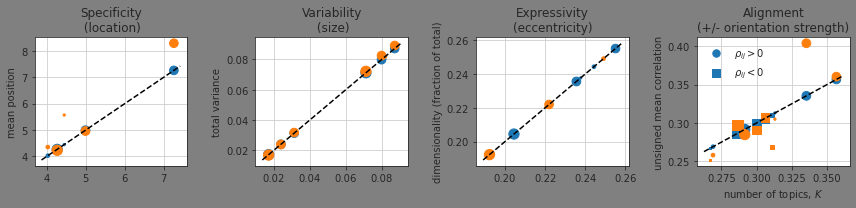

In [114]:
figg,axx=pl.subplots(1,4,figsize=(12,3))
# num_splits=200
Krange=[16,18,20,22,24]

resp_data=fdf.loc[fdf.restype!='notsure',['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
pre_process_stm(resp_data)
pcorp=dict(robjects.r.processed_corpus.items())
for rit,restype in enumerate(['support','oppose']):
    dim_K=[]
    pos_K=[]
    var_K=[]
    vardet_K=[]
    corrpos_K=[]
    corrneg_K=[]
    likeli_K=[]
    for K in Krange:
        filename=f'../../output/stm_models/2019/all_responses_allfac_likelihood_sigmad6_all_K_'+str(K)+'_seed_101_splitseed_'+str(split_seed)
        robjects.r('load(file = "'+filename+'.rda")');

        fitobj=dict(robjects.r.fitobj.items())
        outvar='mu'
        mu_arr=dict(fitobj[outvar].items())[outvar]
        mu_arr=mu_arr[:,pcorp['meta']['restype'].values==restype] 

        covariance_matrix=np.cov(mu_arr)#pl.imshow(np.cov(mu_arr))
        cov_eigen_values, cov_eigen_vectors=linalg.eigh(covariance_matrix)
        dim_K.append((np.sum(cov_eigen_values)**2)/np.sum(np.power(cov_eigen_values,2))/len(covariance_matrix[0,:]))
        pos_K.append(np.mean(np.linalg.norm(mu_arr,axis=1)/np.sqrt(K-1)))
        vardet_K.append(np.power(np.linalg.det(covariance_matrix),1/len(covariance_matrix[0,:])))
        var_K.append(np.sqrt(np.trace(covariance_matrix))/len(covariance_matrix[0,:]))
        correlation_matrix = np.corrcoef(mu_arr)
        corr_thresh = 0.01
        orientation = np.mean(correlation_matrix[(correlation_matrix>0) & (~np.eye(K-1,dtype=bool))])#/np.mean(correlation_matrix[(correlation_matrix<0.01) & (~np.eye(K-1,dtype=bool))])#/(K**2-K)
        corrpos_K.append(orientation)
        orientation = np.fabs(np.mean(correlation_matrix[(correlation_matrix<0) & (~np.eye(K-1,dtype=bool))]))#/np.mean(correlation_matrix[(correlation_matrix<0.01) & (~np.eye(K-1,dtype=bool))])#/(K**2-K)
        corrneg_K.append(orientation)
        robjects.r(
        f'heldout <-make.heldout(processed_corpus$documents,vocab=processed_corpus$vocab,N=floor(.1*length(processed_corpus$documents)),seed={split_seed})'
        );
        likeli_K.append(robjects.r('eval.heldout(fitobj,heldout$missing)$expected.heldout')[0])
    if restype=='support':
        dim_Kp=dim_K
        pos_Kp=pos_K
        var_Kp=var_K
        vardet_Kp=vardet_K
        corrpos_Kp=corrpos_K
        corrneg_Kp=corrneg_K

        robjects.r('rm(fitobj)')
    likeli_K=np.mean(likelihoods,axis=0)
    axx[0].scatter(pos_Kp,pos_K,s=likeli_K)
#     axx[0].set_ylabel(r'$\mathbb{E}\left[|| \theta||\right]/\sqrt{K-1}$')
    p=axx[1].scatter(var_Kp,var_K,s=likeli_K)
    axx[1].scatter(vardet_Kp,vardet_K,s=likeli_K,color=p[-1].get_color())
#     axx[1].set_ylim(0,0.5)
    axx[2].scatter(dim_K,dim_K,s=likeli_K)
#     axx[2].set_ylim(0,1)
#     for ax in axx:
#         ax.set_xticks(range(4,40,4))
    if rit==0:
        p=axx[3].scatter(corrpos_Kp,corrpos_K,s=likeli_K,label=r'$\rho_{ij}>0$')
        axx[3].scatter(corrneg_Kp,corrneg_K,s=likeli_K,c=p[-1].get_color(),ls='--',label=r'$\rho_{ij}<0$')
    else:
        p=axx[3].plot(corrpos_Kp,corrpos_K,s=likeli_K)
        axx[3].plot(corrneg_Kp,corrneg_K,s=likeli_K,c=p[-1].get_color(),ls='--')
    #         axx[3].spines['bottom'].set_position('zero')
for ax in axx:
    ax.plot(ax.get_xlim(),ax.get_xlim(),'k--')
axx[0].legend(frameon=False)
# axx[0].set_xlabel(r'number of topics, $K$')
axx[0].set_ylabel(r'mean position')
axx[0].set_title('Specificity\n (location)')
# ax[2].set_xlabel(r'# effective dimensions')
# axx[1].set_xlabel(r'number of topics, $K$')
axx[1].set_ylabel('total variance')
axx[1].set_title('Variability\n (size)')
#         ax[1].set_ylim(0,0.5)

# axx[2].set_xlabel(r'number of topics, $K$')
axx[2].set_ylabel(r'dimensionality (fraction of total)')
axx[2].set_title('Expressivity\n(eccentricity)')

axx[3].set_xlabel(r'number of topics, $K$')
axx[3].set_ylabel(r'unsigned mean correlation')
axx[3].set_title('Alignment\n(+/- orientation strength)')
# axx[3].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axx[3].legend(frameon=False)
figg.tight_layout()

In [93]:
mu_arr.shape

(17, 2864)

In [49]:
robjects.r('load(file = "'+'../../output/stm_models/2019/all_responses_sep_all_likeli_sigmad6_separate_support_K_36_seed_101_splitseed_200'+'.rda")');
fitobj=dict(robjects.r.fitobj.items())
for outvar in ['mu', 'sigma', 'beta', 'theta', 'eta', 'invsigma']:
    if outvar=='mu':
        print(outvar+' '+str(dict(fitobj[outvar].items())[outvar].shape))
        print('gamma'+' '+str(dict(fitobj[outvar].items())['gamma'].shape))
    elif outvar=='beta':
        print(outvar+' '+str(dict(fitobj['beta'].items())['log'+outvar][0].shape))
    else:
        print(outvar+' '+str(fitobj[outvar].shape))

mu (35, 1295)
gamma (23, 35)
sigma (35, 35)
beta (36, 695)
theta (1295, 36)
eta (1295, 35)
invsigma (35, 35)


In [50]:
outvar='mu'
mu_arr=dict(fitobj[outvar].items())[outvar]
len(np.unique(mu_arr.T,axis=0))

875

In [51]:
len(fdf.loc[fdf.restype=='support',meta_data_names[1:]].drop_duplicates())

880

Compute pairwise distances (supplemental figure)

In [209]:
def get_dist(mu_arr):
    dist_arr=[]
    for rit,row in enumerate(mu_arr.T):
        for rit1,row1 in enumerate(mu_arr.T):
            if rit<rit1:
                dist_arr.append(np.linalg.norm(row-row1))
    return dist_arr

In [214]:
resp_data=fdf.loc[fdf.restype!='notsure',['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
pre_process_stm(resp_data)
pcorp=dict(robjects.r.processed_corpus.items())

K=20
split_seed=1
filename=f'../../output/stm_models/2019/all_responses_allfac_likelihood_sigmad6_all_K_'+str(K)+'_seed_101_splitseed_'+str(split_seed)
robjects.r('load(file = "'+filename+'.rda")');

fitobj=dict(robjects.r.fitobj.items())
outvar='mu'
mu_arr=dict(fitobj[outvar].items())[outvar]

mu_arr_sup=mu_arr[:,pcorp['meta']['restype'].values=='support']
dist_arr_combsup=get_dist(mu_arr_sup)

mu_arr_opp=mu_arr[:,pcorp['meta']['restype'].values=='oppose']
dist_arr_combopp=get_dist(mu_arr_opp)

Sigma_comb=fitobj['sigma']

restype='support'
filename='../../output/stm_models/2019/all_responses_sep_all_likeli_sigmad6_separate_'+restype+'_K_'+str(K)+'_seed_101_splitseed_'+str(split_seed)
robjects.r('load(file = "'+filename+'.rda")');
fitobj=dict(robjects.r.fitobj.items())
mu_arr=dict(fitobj[outvar].items())['mu']
dist_arr_sepsup=get_dist(mu_arr)
Sigma_sepsup=fitobj['sigma']

restype='oppose'
filename='../../output/stm_models/2019/all_responses_sep_all_likeli_sigmad6_separate_'+restype+'_K_'+str(K)+'_seed_101_splitseed_'+str(split_seed)
robjects.r('load(file = "'+filename+'.rda")');
fitobj=dict(robjects.r.fitobj.items())
mu_arr=dict(fitobj[outvar].items())['mu']
dist_arr_sepopp=get_dist(mu_arr)
Sigma_sepopp=fitobj['sigma']



Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 902 of 2104 terms (902 of 23312 tokens) due to frequency 
Removing 8 Documents with No Words 
Your corpus now has 2864 documents, 1202 terms and 22410 tokens.


In [ ]:
counts,bins=np.histogram(dist_arr,bins=100)
counts,bins=np.histogram(dist_arr,bins=100)

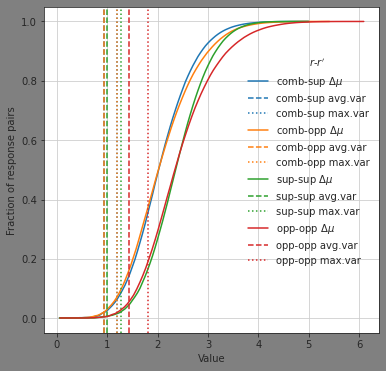

In [232]:
fig,ax=pl.subplots(figsize=(6,6))
for lit,label in enumerate(['comb-sup','comb-opp','sup-sup','opp-opp']):
    if label == 'comb-sup':
        dists=dist_arr_combsup
        sigma_arr=Sigma_comb
    elif label == 'comb-opp':
        dists=dist_arr_combopp
        sigma_arr=Sigma_comb
    elif label == 'sup-sup':
        dists=dist_arr_sepsup
        sigma_arr=Sigma_sepsup
    elif label == 'opp-opp':
        dists=dist_arr_sepopp
        sigma_arr=Sigma_sepopp
    
    
    counts,bins=np.histogram(dists,bins=100,density=True)
    p=ax.plot(bins[1:],np.cumsum(counts)/np.sum(counts),'-',label=label+r' $\Delta\mu$')
    ax.axvline(x=np.power(np.linalg.det(sigma_arr),1/(2*len(sigma_arr[0,:]))),ls='--',color=p[-1].get_color(),label=label+' avg.var')
    ax.axvline(x=np.power(np.max(np.diag(sigma_arr)),1/2),ls=':',color=p[-1].get_color(),label=label+' max.var')

ax.legend(frameon=False,loc=7)
ax.set_ylabel('Fraction of response pairs')
ax.set_xlabel('Value')
ax.text(5,0.85,r"$r$-$r'$")
# ax.axvline(x=np.power(np.trace(sigma_arr)/len(sigma_arr[0,:]),1/2),ls='--',p[-1].get_color())
fig.savefig("distances.png", transparent=True,bbox_inches="tight",dpi=300)


In [238]:
fdf.loc[fdf.restype=='support','resclean'].apply(lambda x:'tax grab' in x).sum()/len(fdf.loc[fdf.restype=='support','resclean'])

0.0

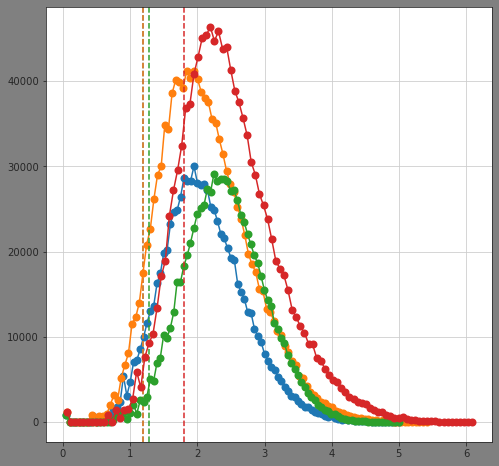

In [216]:
fig,ax=pl.subplots()
for label in ['comb-sup','comb-opp','sup-sup','opp-opp']:
    if label == 'comb-sup':
        dists=dist_arr_combsup
        sigma_arr=Sigma_comb
    elif label == 'comb-opp':
        dists=dist_arr_combopp
        sigma_arr=Sigma_comb
    elif label == 'sup-sup':
        dists=dist_arr_sepsup
        sigma_arr=Sigma_sepsup
    elif label == 'opp-opp':
        dists=dist_arr_sepopp
        sigma_arr=Sigma_sepopp
    
    
    counts,bins=np.histogram(dists,bins=100)
    p=ax.plot(bins[1:],counts,'o-')
    ax.axvline(x=np.power(np.max(np.diag(sigma_arr)),1/2),ls='--',color=p[-1].get_color())
# ax.axvline(x=np.power(np.trace(sigma_arr)/len(sigma_arr[0,:]),1/2),ls='--',p[-1].get_color())